# Interaction term

## Intro

상호작용 변수(interaction term)과 회귀식의 관계 알아보기

## 목적

- 상호작용 변수를 회귀모형에 넣는 것이 이 데이터에 적절한지

- 상호작용 변수를 실제로 만들어보기

- 상호작용 변수가 들어간 회귀모형 해석하기

## 왜 만드는가?

* 변수 간의 상호작용을 알아보기 위해서

* 종속변수 X가 연속형 / 범주형이든 상관없이 적용할 수 있음.

* 여기에서는 연속형 1개, 범주형 1개로 시작.  

예를 들어, 이 그래프는 세개의 변수를 보여주고 있음.

- 그래프는 무게(weight)와 엔진의 기통수(cylinders)에 따른 연비(mpg)를 보여주고 있음.

- `weight`는 x축, `mpg`는 y축. `cylinders`는 색깔임. 

- weight를 표준화했음.

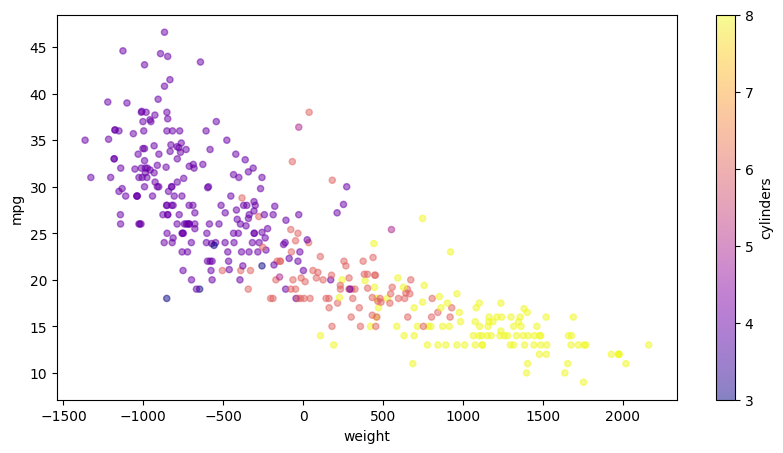

In [79]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

data = pd.read_csv("../_dataset/auto-mpg.csv")
data["weight"] = data["weight"] - data["weight"].mean()
data["model year"] = data["model year"] - 70

fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="cylinders", cmap="plasma", alpha=0.5, ax=ax);

* `cylinders`를 범주형으로 보고, 상호작용 변수(interaction term)을 만들지 않는다고 하자.

* 이때 각 `cylinders`를 표현한 선들은 전부 평행하게 나올 것이다.

In [80]:
def plot_fit_lines(data, results, column, categories, interactions, cmap=mpl.colormaps['plasma']):
    # Extract some shorter variable names for readability
    x = data["weight"]
    beta_0 = results.params["const"]
    beta_1 = results.params["weight"]
    
    # Set up scatter plot
    fig, ax = plt.subplots(figsize=(10,5))
    data.plot.scatter(x="weight", y="mpg", c=column, cmap=cmap, alpha=0.5, ax=ax)

    colors = cmap
    min_cat = data[column].min()
    max_cat = data[column].max()
    range_cat = max_cat - min_cat
    
    # For each category, calculate and graph the fit line
    for cat in categories:
        if cat in interactions:
            fit_line = beta_0 + \
                (beta_1 + results.params[f"weight x {column}_{cat}"]) * x + \
                results.params[f"{column}_{cat}"]
        else:
            fit_line = beta_0 + beta_1 * x + results.params[f"{column}_{cat}"]
            
        ax.plot(
            x,
            fit_line,
            color=colors((cat - min_cat)/range_cat),
            label=f"{column}: {cat}",
            linewidth=5,
            alpha=0.7)

    ax.legend()

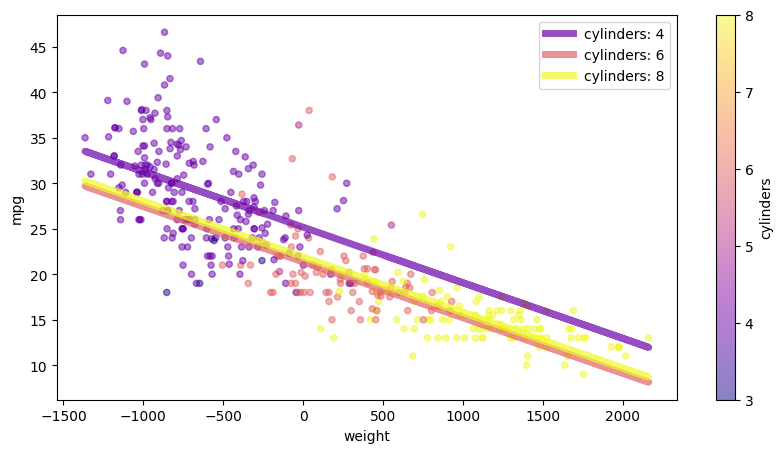

In [81]:
import statsmodels.api as sm

# Prepare data for modeling
y = data["mpg"]
X_no_interaction = data[["cylinders", "weight"]].copy()

# Create dummy variables for the 'cylinders' column
X_no_interaction = pd.get_dummies(X_no_interaction, columns=["cylinders"], drop_first=True)

# Convert the dummy variables to numeric data type
X_no_interaction = X_no_interaction.astype(float)

# Build model and get results
no_interaction_model = sm.OLS(y, sm.add_constant(X_no_interaction))
no_interaction_results = no_interaction_model.fit()

# Plot the lines generated by the model for each selected category
plot_fit_lines(data, no_interaction_results, "cylinders", [4, 6, 8], [])

**<Note>**
* 사실 실제로 자동차들은 3, 4, 5, 6, 8기통만 가지고 있다.
* 그러나, 3기통, 5기통 샘플은 너무 적기에 이를 제외함.

위 그래프를 공식으로 표현하면 다음과 같다.
$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \begin{cases}
  \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

직접 회귀선을 그렸다고 가정했을 때, 과연 저런 평행한 모양이 나올 수 있을까?

* 4기통만을 그린다고 했을때, 훨씬 더 가파른 그래프가 나올 수 밖에 없음.

* 왜? 무게가 올라갔는데, 엔진의 기통수는 그대로(=차의 힘은 그대로)이므로 연비가 떨어질 수밖에 없음

* 따라서 무게와 기통수 간의 상호작용( ***interaction term***)을 넣어줘야 좀 더 정확한 분석을 할 수 있음.

# 예시 1 : 범주형 x 수치형
* interaction term을 만들어보자. 데이터는 4기통 차량에 한정한다고 생각해보자.

* `weight` 곱하기 `cylinders_4`로 만드면 된다.

* 이때 데이터는 다음과 같이 생겼다.

In [82]:
X_no_interaction

,weight,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,526.415816,0.0,0.0,0.0,1.0
1,715.415816,0.0,0.0,0.0,1.0
2,458.415816,0.0,0.0,0.0,1.0
3,455.415816,0.0,0.0,0.0,1.0
4,471.415816,0.0,0.0,0.0,1.0
...,...,...,...,...,...
387,-187.584184,1.0,0.0,0.0,0.0
388,-847.584184,1.0,0.0,0.0,0.0
389,-682.584184,1.0,0.0,0.0,0.0
390,-352.584184,1.0,0.0,0.0,0.0


다음과 같이 상호작용 변수를 넣으면 된다.

In [83]:
X_interaction = X_no_interaction.copy()
X_interaction["weight x cylinders_4"] = X_interaction["weight"] * X_interaction["cylinders_4"]
X_interaction

,weight,cylinders_4,cylinders_5,cylinders_6,cylinders_8,weight x cylinders_4
0,526.415816,0.0,0.0,0.0,1.0,0.000000
1,715.415816,0.0,0.0,0.0,1.0,0.000000
2,458.415816,0.0,0.0,0.0,1.0,0.000000
3,455.415816,0.0,0.0,0.0,1.0,0.000000
4,471.415816,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...
387,-187.584184,1.0,0.0,0.0,0.0,-187.584184
388,-847.584184,1.0,0.0,0.0,0.0,-847.584184
389,-682.584184,1.0,0.0,0.0,0.0,-682.584184
390,-352.584184,1.0,0.0,0.0,0.0,-352.584184


그리고 모델을 만들고, 결과를 보면...

In [84]:
# Build model and get results
interaction_model = sm.OLS(y, sm.add_constant(X_interaction))
interaction_results = interaction_model.fit()
interaction_results.params

const                   18.243773
weight                  -0.003983
cylinders_4              5.082207
cylinders_5              9.623695
cylinders_6              2.623946
cylinders_8              1.248019
weight x cylinders_4    -0.004877
dtype: float64

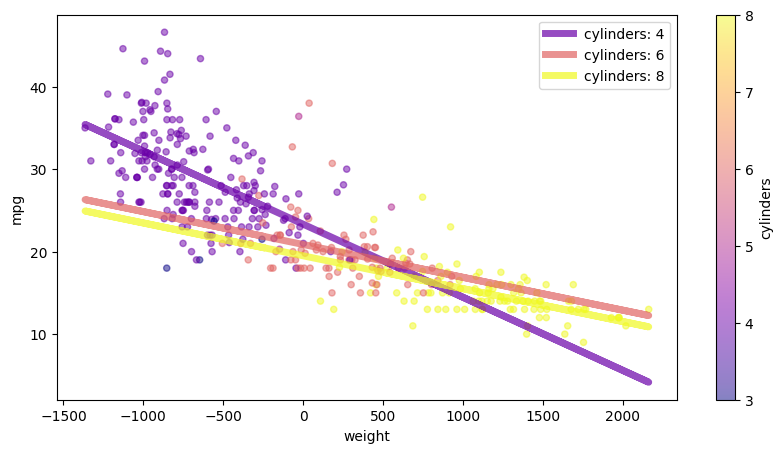

In [85]:
plot_fit_lines(data, interaction_results, "cylinders", [4, 6, 8], [4])

이를 공식으로 적어보면 다음과 같다.

$$ \large{ \text{mpg} = \beta_0 + \begin{cases}
  \beta_1 \times \text{weight} + \beta_\text{interaction} + \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

**<Note>**

* 여기서의 $\beta$값 : 앞의 식의 $\beta$값과 다름

* 4기통일때의 $\beta_\text{(4 cylinders)}$ 가 훨씬 더 가파름.

* 즉, 변수를 추가함으로써 모형의 추정 결과가 달라지게 됨. 

## 상호작용 변수의 평가
* 상호작용 변수의 추가가 모델을 더 향상시켰는가?

* 상호작용 변수의 추가가 다른 정보를 더 줄 수 있는가?

* 시각화 결과가 좀 더 현실에 가까워진 것으로도 더 정보를 준다고 평가할 수 있다.  

* 그렇지만, 아직 좀 더 따져야 할 것들이 있다.

1. 상호작용 변수는 통계적으로 유의한가?

2. 상호작용 변수가 들어간 모델은 더 좋은가?

### 통계적 유의성 확인하기


In [86]:
pvalues_df = pd.DataFrame(interaction_results.pvalues, columns=["p-value"])
pvalues_df["p < 0.05"] = pvalues_df["p-value"] < 0.05
pvalues_df

,p-value,p < 0.05
const,2.832364e-17,True
weight,1.029030e-07,True
cylinders_4,1.866970e-02,True
cylinders_5,2.172974e-03,True
cylinders_6,2.216976e-01,False
cylinders_8,6.045203e-01,False
weight x cylinders_4,1.478591e-05,True


<결과해석>
* `weight`, `cylinders_4`, `weight x cylinders_4`는 전부 통계적으로 유의적이다.

* 회귀계수들의 p-value가 전부 0.05보다 작기 때문이다.

* 이는 상호작용 변수의 추가가 옳은 선택임을 의미한다

### 모형 진단하기
원래 모델의 $R^2$ 값은 다음과 같다 :

In [87]:
rsquared_origin = no_interaction_results.rsquared_adj
print(rsquared_origin)

0.7213409417018846


그리고, 상호작용을 추가한 모델의 $R^2$ 값은 다음과 같다 :

In [88]:
rsquared_interaction = interaction_results.rsquared_adj
print(rsquared_interaction)

0.733924573658242


작지만 모델이 개선된 효과가 있음을 알 수 있다.

## 상호작용 변수의 해석

* `const`, `cylinders_4`, `weight`, `weight x cylinders_4`가 전부 통계적으로 유의하다는 것이 밝혀짐.

* 따라서 인제 그들의 의미를 모델의 관점에서 해석해보자.

In [89]:
interaction_results.params

const                   18.243773
weight                  -0.003983
cylinders_4              5.082207
cylinders_5              9.623695
cylinders_6              2.623946
cylinders_8              1.248019
weight x cylinders_4    -0.004877
dtype: float64

<`const`의 의미 해석>
* intercept coefficients(절편 계수)의 의미를 해석해보자.

* intercept coefficients(절편 계수) 값은 18.243773

* reference 관점에서 우리는 갤론 당 18 마일의 연비를 기대할 수 있음.

* reference : 기본적인 상황. 즉 여기서는 3기통과 평균 `weight`를 이야기

<`cylinders_4`의 의미>
* `cylinders_4` = 5.082207

* 이는 4기통의 장착이 연비를 갤론 당 5마일 더 늘릴 수 있음을 의미.

<둘을 더한다면?>

* `const` + `cylinders_4` = 23

* 4기통을 가지고, 평균 무게를 가진 차량은 갤론 당 23마일의 연비를 기대할 수 있음.

<`weight`의 의미>
* `weight` = -0.003983

* 4기통이 아닌 다른 차량에서는 갤론 당 약 -0.004마일 만큼 연비가 감소 

* 4기통이 아닐 경우, `weight x cylinders_4`가 아닌 `weight`만 가지고 판단하기 때문

<`weight x cylinders_4`의 의미>
* `weight x cylinders_4` = -0.004877

* 4기통인 차량에서는 갤론 당 약 -0.005마일 만큼 연비가 감소 

즉, 이를 종합하면 4기통이면서 평균적인 무게를 갖는 차량은 다음과 같이 연비가 나옴을 알 수 있다.

In [90]:
final_mpg = interaction_results.params["weight x cylinders_4"] + interaction_results.params["weight"]
print(f"갤론 당 {np.round(final_mpg, 3)}마일의 연비 감소가 일어남")
print(f"그래프의 기울기 = {np.round(final_mpg, 3)}만큼 더 기울어짐")


갤론 당 -0.009마일의 연비 감소가 일어남
그래프의 기울기 = -0.009만큼 더 기울어짐


# 예시 2 : 수치형 x 수치형

It is also possible to create an interaction term between two numeric features rather than one numeric feature (e.g. `weight`) and one categorical feature (e.g. `cylinders_4`).

Let's take a look at `weight` vs. `model year`:

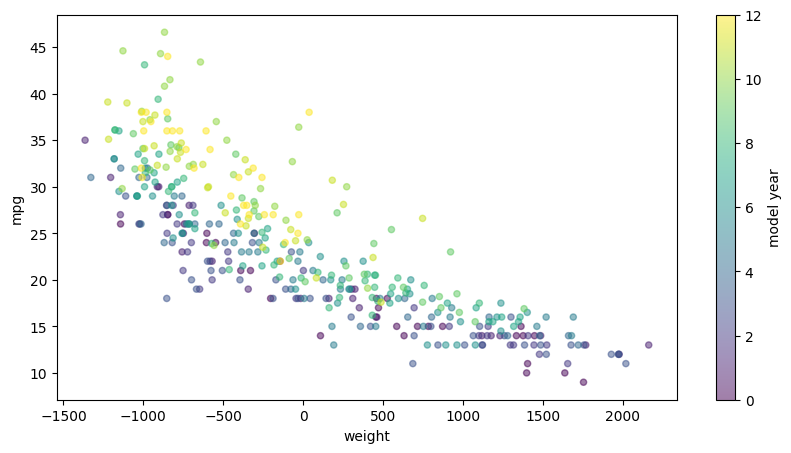

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="model year", cmap="viridis", alpha=0.5, ax=ax);

EDA를 위해 다음과 같은 사항을 적용할 수 있다.
* `years`를 범주형 변수로 만들기

* 그리고 피팅을 시켜서 시각화를 한다.

In [92]:
X_many_interactions = data[["weight", "model year"]].copy()
X_many_interactions = pd.get_dummies(X_many_interactions, columns=["model year"], drop_first=True)

# skip first year value because this was dropped in one-hot encoding
years = data["model year"].unique()[1:]

for year in years:
    X_many_interactions[f"weight x model year_{year}"] = X_many_interactions["weight"] * \
                                                            X_many_interactions[f"model year_{year}"]


In [93]:
# Build model and get results
many_interactions_model = sm.OLS(y, sm.add_constant(X_many_interactions.astype(float)))
many_interactions_results = many_interactions_model.fit()


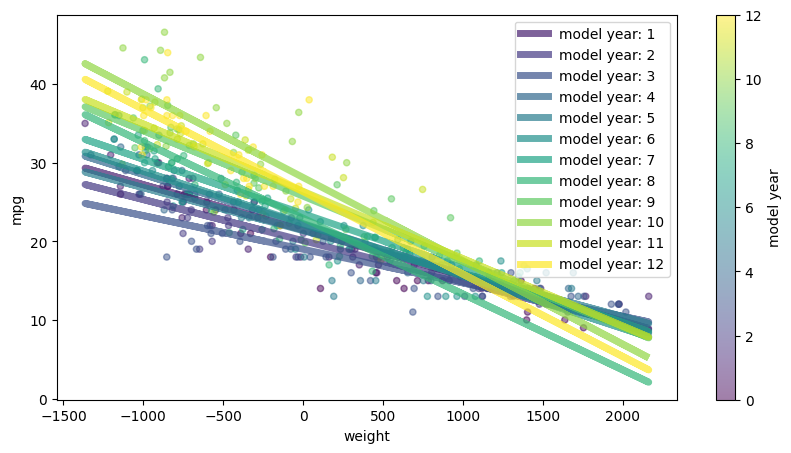

In [94]:
# Plot many fit lines
# (Remember, a model year of 1 means 1971)
plot_fit_lines(data, many_interactions_results, "model year", years, years, cmap=mpl.colormaps['viridis'])

## plot 해석하기

* model year 가 나중으로 갈수록 그래프가 점점 가팔라지는 것을 볼 수 있음.

* 그래서, 각각의 model year를 따지지 말고, `model year`를 하나의 수치형 변수로 생각.

* 또한, `weight x model year`라는 새로운 상호작용 변수를 도입.

In [95]:
# Prepare data with a single interaction term of weight x model year
X_numeric_interaction = data[["weight", "model year"]].copy()
X_numeric_interaction["weight x model_year"] = X_numeric_interaction["weight"] * X_numeric_interaction["model year"]
X_numeric_interaction

,weight,model year,weight x model_year
0,526.415816,0,0.000000
1,715.415816,0,0.000000
2,458.415816,0,0.000000
3,455.415816,0,0.000000
4,471.415816,0,0.000000
...,...,...,...
387,-187.584184,12,-2251.010204
388,-847.584184,12,-10171.010204
389,-682.584184,12,-8191.010204
390,-352.584184,12,-4231.010204


In [96]:
# Build model and get results
numeric_interaction_model = sm.OLS(y, sm.add_constant(X_numeric_interaction))
numeric_interaction_results = numeric_interaction_model.fit()

* 이 모형이 어떻게 작동하는지 알기 위해 3차원 plot을 이용해보자.

* 기존처럼 x축에는 `weight`가, y축에는 `mpg`가 들어가나, 새롭게 z축으로 `model year`를 넣어보자.

* 다른 각도에서 보면서 해석을 해보자.

Text(0.5, 0, 'model year')

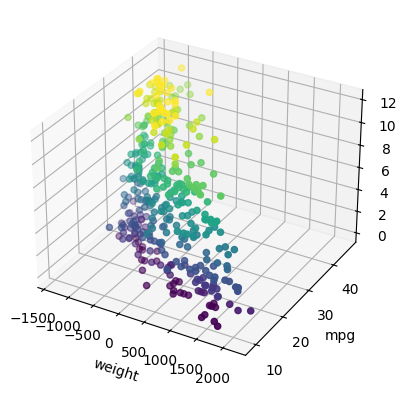

In [97]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("mpg")
ax.set_zlabel("model year")

모형을 좀 더 확실하게 보기 위해 초평면을 그려보자.

In [98]:
import numpy as np

# Find 50 evenly-spaced points in the ranges of weight and model year and create meshes
weights = np.linspace(data["weight"].min(), data["weight"].max() + 1, 50)
years = np.linspace(data["model year"].min(), data["model year"].max() + 1, 50)
weights, years = np.meshgrid(weights, years)

# Extract relevant values from modeling results
constant = numeric_interaction_results.params["const"]
weight_coef = numeric_interaction_results.params["weight"]
year_coef = numeric_interaction_results.params["model year"]
interaction_coef = numeric_interaction_results.params["weight x model_year"]

# Make a hyperplane of predictions using the values extracted from the model
predictions = (
    # beta 0
    constant + \
    # beta 1 times weight
    weight_coef * weights + \
    # beta 2 times model year
    year_coef * years + \
    # beta 3 times weight times model year
    interaction_coef * weights * years
)

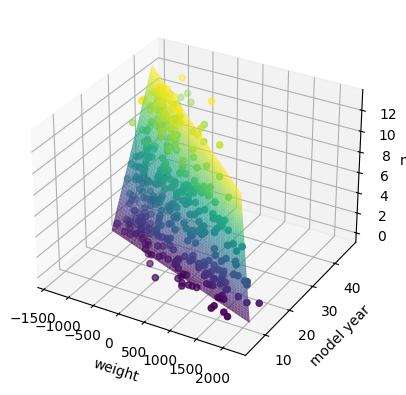

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("model year")
ax.set_zlabel("mpg")

# Plot surface of predictions on the same axes
ax.plot_surface(
    weights,        # x
    predictions,    # y
    years,          # z
    cmap="viridis", # color is drawn from z axis value
    alpha=0.7
)

이를 시각화한 공식은 다음과 같다.

$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year} + \beta_3 \times \text{weight} \times \text{model year} } $$

* 이 초평면은 상호작용 변수 때문에 조금 휘어졌다.

* 만약 우리가 상호작용 변수 없이 공식을 다음과 만둘었다고 해보자.
$$\text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year}$$

* 시각화를 했을 때 더 평평한 초평면이 그려졌을 것이다.

## 상호작용 변수의 해석

* 수치형 x 수치형의 상호작용 변수는 조금 더 평가하기 까다롭다. 단순히 x가 있으면 y가 증가한다! 라는 식으로 말할 수 없다.

* 대신, 이러한 모델은 한 변수의 변화가 다른 변수의 변화에 영향을 끼친다고 해석해야 한다.

* 실제로 이 예시를 통해 해석을 진행해보자.

In [100]:
numeric_interaction_results.pvalues

const                  9.257577e-197
weight                  1.673750e-33
model year              1.136337e-37
weight x model_year     8.015486e-14
dtype: float64

In [101]:
numeric_interaction_results.params

const                  18.956272
weight                 -0.004509
model year              0.676944
weight x model_year    -0.000458
dtype: float64

<`const` 해석하기>

* 절편의 해석은 분명하다.

* 절편의 값은 약 19로, 평균 무게와 1970년에 나온 차량의 연비는 19라는 의미다.

* (우리가 절편 해석을 위해 `weight`에서 평균을 빼고, `model_year`에서 70을 뺐음을 기억하자. )

<하나씩 해석하기>

* 우리가 `weight`만 해석하거나, `model_year`만 해석하는 방법 중 하나는 다른 predictor를 0으로 만드는 것이다.

* 이를 통해서 상호작용 변수인 `weight x model_year`를 무시할 수 있다.

* 이 경우 다음과 같이 해석이 가능하다.

1. 1970년에 출시한 차량의 경우, 1파운드가 늘수록 0.005 mpg만큼의 연비가 감소한다.

2. 평균적인 무게를 가진 챠량의 경우, 출시연도(model year)가 늘어날 수록 0.7 mpg만큼의 연비가 증가한다.

<합쳐서 해석하기>

* 그렇다면, 1970년에 출시하지도 않고, 평균 무게도 아닌 차량은 어떨까?

* 이럴 때, 상호작용 변수인 `weight x model year`의 값, 0.005를 해석한다.

1. 무게가 늘어날수록, 0.005 + (0.0005 x model year) 만큼의 연비 감소가 나타난다.

2. 해가 지날수록, 0.7 - (0.0005 x weight) mpg만큼의 연비 향상이 나타난다.

* 하나씩 해석하는 것과 합쳐서 해석하는 것 중 어떤 것을 선택할지는 문맥에 따라 달라지게 된다. 

# 고급 : Scikit-Learn

* scikit-learn을 이용해서 모든 변수들의 상호작용 조합을 만들어 보자.

* `PolynomialFeatures` 클래스와 `interaction_only` 파라미터를 이용하면 된다.

* ([참고 문서](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

In [105]:
# Prep subset of data for creating interactions
sklearn_data = data.drop("origin", axis=1).select_dtypes("number")
sklearn_data.rename(columns={"model year": "model_year"}, inplace=True)
sklearn_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
0,18.0,8,307.0,130,526.415816,12.0,0
1,15.0,8,350.0,165,715.415816,11.5,0
2,18.0,8,318.0,150,458.415816,11.0,0
3,16.0,8,304.0,150,455.415816,12.0,0
4,17.0,8,302.0,140,471.415816,10.5,0
...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,-187.584184,15.6,12
388,44.0,4,97.0,52,-847.584184,24.6,12
389,32.0,4,135.0,84,-682.584184,11.6,12
390,28.0,4,120.0,79,-352.584184,18.6,12


In [106]:
# Separate X and y
y = sklearn_data["mpg"]
X = sklearn_data.drop("mpg", axis=1)

In [104]:
from sklearn.preprocessing import PolynomialFeatures

# Fit a PolynomialFeatures transformer on X
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
poly.fit(X)

# Create transformed version of X that has all of the original features plus
# interactions between all features
new_col_names = pd.Series(poly.get_feature_names_out(X.columns)).str.replace(" ", " x ")
X_interactions = pd.DataFrame(poly.transform(X), columns=new_col_names)
X_interactions

,cylinders,displacement,horsepower,weight,acceleration,model_year,cylinders x displacement,cylinders x horsepower,cylinders x weight,cylinders x acceleration,...,displacement x horsepower,displacement x weight,displacement x acceleration,displacement x model_year,horsepower x weight,horsepower x acceleration,horsepower x model_year,weight x acceleration,weight x model_year,acceleration x model_year
0,8.0,307.0,130.0,526.415816,12.0,0.0,2456.0,1040.0,4211.326531,96.0,...,39910.0,161609.655612,3684.0,0.0,68434.056122,1560.0,0.0,6316.989796,0.000000,0.0
1,8.0,350.0,165.0,715.415816,11.5,0.0,2800.0,1320.0,5723.326531,92.0,...,57750.0,250395.535714,4025.0,0.0,118043.609694,1897.5,0.0,8227.281888,0.000000,0.0
2,8.0,318.0,150.0,458.415816,11.0,0.0,2544.0,1200.0,3667.326531,88.0,...,47700.0,145776.229592,3498.0,0.0,68762.372449,1650.0,0.0,5042.573980,0.000000,0.0
3,8.0,304.0,150.0,455.415816,12.0,0.0,2432.0,1200.0,3643.326531,96.0,...,45600.0,138446.408163,3648.0,0.0,68312.372449,1800.0,0.0,5464.989796,0.000000,0.0
4,8.0,302.0,140.0,471.415816,10.5,0.0,2416.0,1120.0,3771.326531,84.0,...,42280.0,142367.576531,3171.0,0.0,65998.214286,1470.0,0.0,4949.866071,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,4.0,140.0,86.0,-187.584184,15.6,12.0,560.0,344.0,-750.336735,62.4,...,12040.0,-26261.785714,2184.0,1680.0,-16132.239796,1341.6,1032.0,-2926.313265,-2251.010204,187.2
388,4.0,97.0,52.0,-847.584184,24.6,12.0,388.0,208.0,-3390.336735,98.4,...,5044.0,-82215.665816,2386.2,1164.0,-44074.377551,1279.2,624.0,-20850.570918,-10171.010204,295.2
389,4.0,135.0,84.0,-682.584184,11.6,12.0,540.0,336.0,-2730.336735,46.4,...,11340.0,-92148.864796,1566.0,1620.0,-57337.071429,974.4,1008.0,-7917.976531,-8191.010204,139.2
390,4.0,120.0,79.0,-352.584184,18.6,12.0,480.0,316.0,-1410.336735,74.4,...,9480.0,-42310.102041,2232.0,1440.0,-27854.150510,1469.4,948.0,-6558.065816,-4231.010204,223.2


* 너무 변수가 많아서 해석하기 어렵다.
* 따라서, 반드시 모델을 고르는 과정이 필요하다.